# Explorando dados para estartégia de redução do Churn

Objetivos da análise:

- Visualizar quais serviços tem maior taxa de avaliações negativas e suas métricas de grandeza
- Entender qual serviço tem maior janela de oportunidade e quais apresentam maior ameaça em relação ao churn
- Traçar grupos para cada tipo de serviço prestado
- Observar grupos de clientes e traçar perfis para criar estratégias e evitar churn

In [1]:
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from kmodes.kprototypes import KPrototypes
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Definindo as pastas do diretório

root = os.getcwd()
dataFolder = os.path.join(root, 'data')
docFolder = os.path.join(root, 'doc')

In [30]:
# Definindo cores do Seaborn

sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.set_palette('rocket')

# 01) Importantdo os dados tratados

In [4]:
df = pd.read_csv(os.path.join(dataFolder, 'dados_tratados.csv'), sep=';')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102 entries, 0 to 101
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Nome                            102 non-null    object 
 1   Idade                           102 non-null    int64  
 2   Gênero                          102 non-null    object 
 3   Estado Civil                    102 non-null    object 
 4   Número de Dependentes           102 non-null    int64  
 5   Data de Início do Contrato      102 non-null    object 
 6   Data de Término do Contrato     4 non-null      object 
 7   Valor Mensal do Contrato        102 non-null    float64
 8   Tipo de Serviço                 102 non-null    object 
 9   Duração Média das Chamadas      102 non-null    float64
 10  Comentários                     102 non-null    object 
 11  Última data de contrato ativo   102 non-null    object 
 12  Houve término de contrato       102 

In [5]:
# Transformando o tempo de contrato em variável int

df['Tempo ativo de contrato - dias'] = df['Tempo ativo de contrato - dias'].str.removesuffix('days').astype('int')

# 02) Observando historicamente a grandeza e a qualidade dos serviços

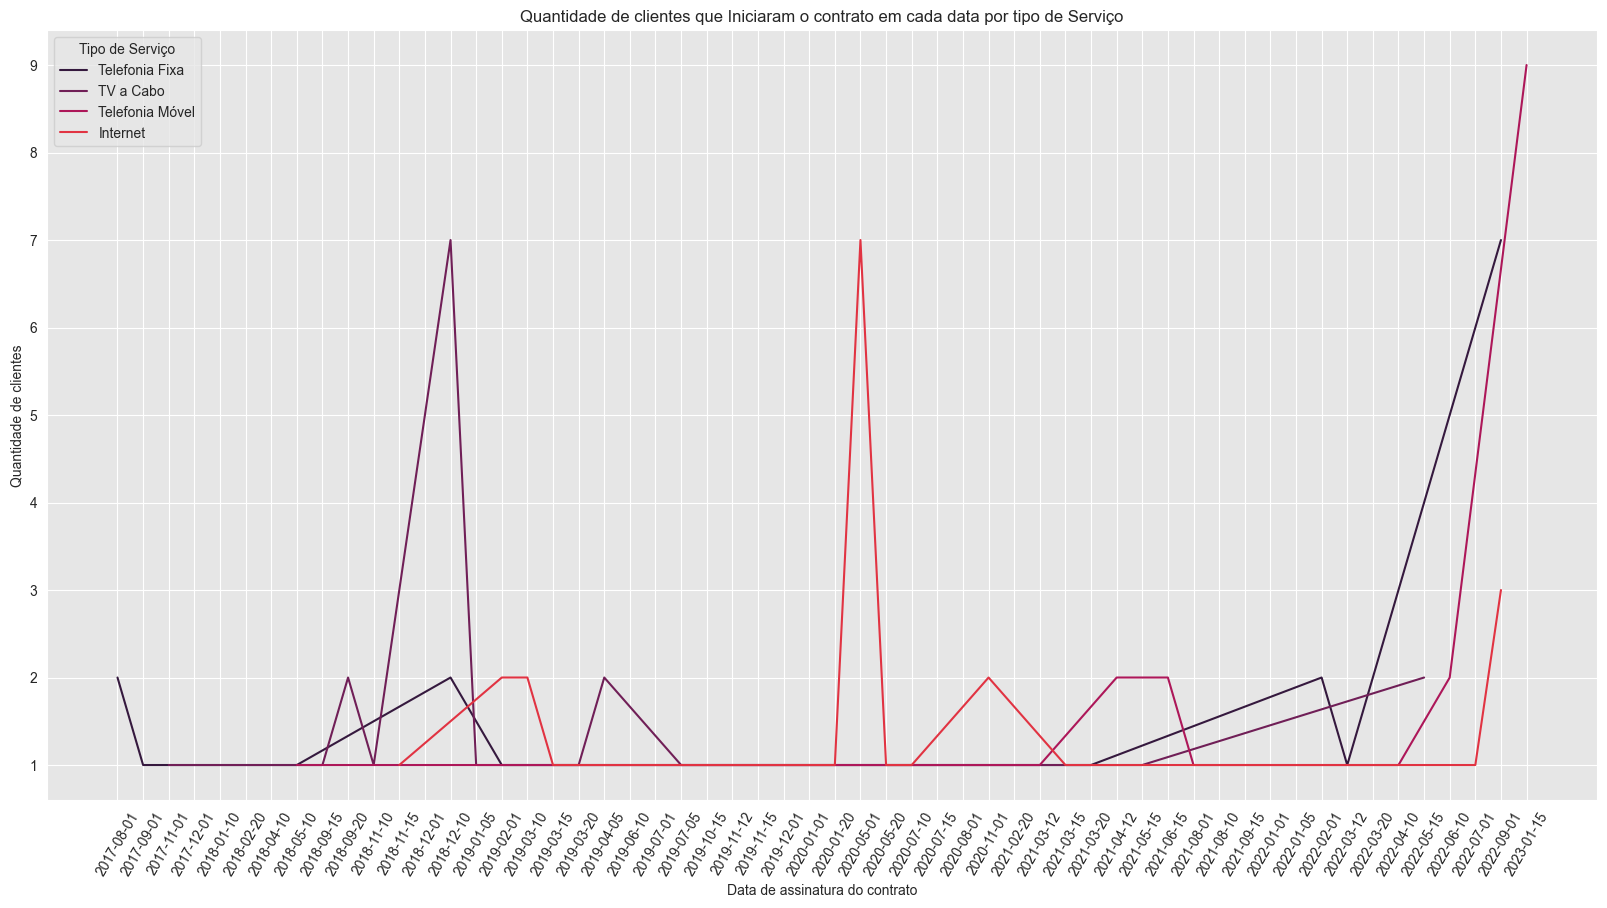

In [59]:
# Vendo a quantidade de clientes que assinaram o serviço por data

df_serie_historica_qtd = pd.DataFrame(df.groupby(['Tipo de Serviço', 'Data de Início do Contrato']).size()).reset_index().sort_values('Data de Início do Contrato')

plt.figure(figsize=(20,10))
sns.lineplot(data=df_serie_historica_qtd, x='Data de Início do Contrato', y=0, hue='Tipo de Serviço')
plt.title("Quantidade de clientes que Iniciaram o contrato em cada data por tipo de Serviço")
plt.ylabel("Quantidade de clientes")
plt.xlabel("Data de assinatura do contrato")
plt.xticks(rotation = 60)

path_fig = os.path.join(docFolder, 'serie_historica_contratos.png')
plt.savefig(path_fig)

plt.show()

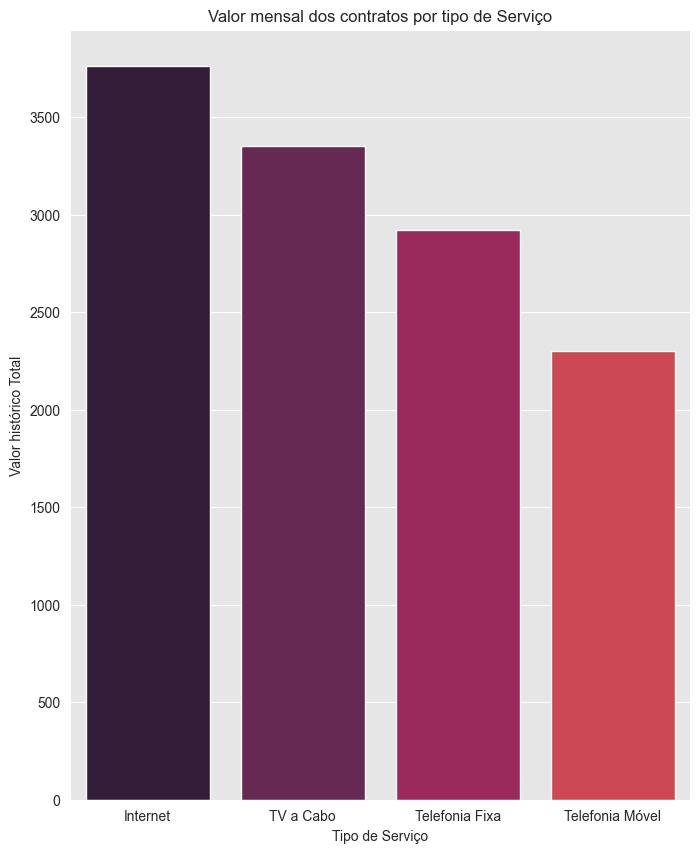

In [55]:
# Vendo o valor mensal dos contratos dos clientes por tipo de serviço

df_valor_agregado = pd.DataFrame(df.groupby('Tipo de Serviço')['Valor Mensal do Contrato'].sum()).reset_index()

plt.figure(figsize=(8,10))
sns.barplot(data=df_valor_agregado, x='Tipo de Serviço', y='Valor Mensal do Contrato')
plt.title("Valor mensal dos contratos por tipo de Serviço")
plt.ylabel("Valor histórico Total")
plt.xlabel("Tipo de Serviço")

path_fig = os.path.join(docFolder, 'valor_contratos_servico.png')
plt.savefig(path_fig)

plt.show()

In [50]:
# Estatísticas descritivas dos valores de contratos mensal para cada serviço

print("Estatísticas descritivas:\n")
df[['Tipo de Serviço', 'Valor Mensal do Contrato']].groupby('Tipo de Serviço').describe()

Estatísticas descritivas:



Valor Mensal do Contrato                                \
                                   count        mean        std    min   
Tipo de Serviço                                                          
Internet                            31.0  121.280323  22.618862  69.99   
TV a Cabo                           25.0  133.990000  24.152295  99.99   
Telefonia Fixa                      23.0  126.946522  32.673979  99.99   
Telefonia Móvel                     23.0   99.990000  17.580981  79.99   

                                                 
                    25%     50%     75%     max  
Tipo de Serviço                                  
Internet          99.99  119.99  144.99  149.99  
TV a Cabo        109.99  129.99  149.99  179.99  
Telefonia Fixa    99.99  109.99  144.99  189.99  
Telefonia Móvel   89.99   89.99  109.99  149.99

In [61]:
# Valor total de contribuição para cada serviço

print("Contribuição histórica para o faturamento total por tipo de serviço:\n")
df_valor_agregado.sort_values('Valor Mensal do Contrato', ascending=False)
df_valor_agregado['Percentual total'] =  (df_valor_agregado['Valor Mensal do Contrato'] / (df_valor_agregado['Valor Mensal do Contrato'].sum())) * 100

df_valor_agregado

Contribuição histórica para o faturamento total por tipo de serviço:



,Tipo de Serviço,Valor Mensal do Contrato,Percentual total
0,Internet,3759.69,30.494737
1,TV a Cabo,3349.75,27.169725
2,Telefonia Fixa,2919.77,23.682170
3,Telefonia Móvel,2299.77,18.653368


# 03) Observando quais serviços tem maior janela de oportunidade de melhoria em relação aos comentários

In [ ]:
# Criando uma função que ploa o Histograma de uma variável X qualquer e salva sua imagem na pasta doc

def plot_histograma(variavel_x, titulo, nome_figura):
    plt.figure(figsize=(8,5))

    sns.histplot(data=df, x=variavel_x, hue='Avaliações - GPT', kde=True, multiple="dodge")

    plt.title(titulo)
    plt.ylabel("Quantidade de clientes")

    path_fig = os.path.join(docFolder, nome_figura)
    plt.savefig(path_fig)

    plt.show()

# 04) Observando quais variáveis provavelmente estão mais ligadas a avaliações negativas dos produtos

In [ ]:
# Visualizando a correlação linear (Pearson) das variáveis numéricas

matriz_correlacao = df.select_dtypes(['int', 'float']).corr()
mask = np.triu(matriz_correlacao)

plt.figure(figsize=(10,4))
sns.heatmap(matriz_correlacao, vmin = -1, vmax = +1, annot = True, cmap = 'viridis', mask = mask)
plt.title("Correlação Linear das variáveis numéricas")

plt.savefig(os.path.join(docFolder, 'correlacao_pearson.png'))
plt.show()

# 05) Traçando grupos para cada tipo de serviço prestado

In [75]:
# Separando diferentes dataframes de acordo com o serviço para facilitar análises futuras
# Assim, como dataframe original e os particionados é possível prosseguir com a clusterização dos grupos

df_cluster = df.drop(columns=['Nome', 'Data de Início do Contrato', 'Data de Término do Contrato', 'Comentários', 'Última data de contrato ativo', 'Houve término de contrato'])

df_telefone_movel = df_cluster[df_cluster['Tipo de Serviço'] == 'Telefonia Móvel']
df_telefone_fixo = df_cluster[df_cluster['Tipo de Serviço'] == 'Telefonia Fixa'].drop(columns=['Volume de Dados - GB', 'Duração Média das Chamadas'])
df_internet = df_cluster[df_cluster['Tipo de Serviço'] == 'Internet'].drop(columns=['Volume de Dados - GB', 'Duração Média das Chamadas'])
df_tv = df_cluster[df_cluster['Tipo de Serviço'] == 'TV a Cabo'].drop(columns=['Volume de Dados - GB', 'Duração Média das Chamadas'])

In [99]:
# Função que determina a clusterização dos dados e retorna os pontos centrais
# Faz a separação de variáveis numéricas e categoricas para utilizar o método KPrototypes
# Esse método lida com os dois tipos de variáveis de forma distinta de uma única vez (separação por distância para numéricas e prob. para textuais)

def make_cluster(dataframe, max_cluster):

    # Separa variaveis categoricas das numericas
    dados_numericos = dataframe.select_dtypes(['int', 'float'])
    dados_textual = dataframe.drop(columns=dados_numericos.columns)

    # Normaliza os dados numericos
    scaler = MinMaxScaler().fit(dados_numericos)
    df_scaler = scaler.fit_transform(dados_numericos)
    df_escala = pd.DataFrame(df_scaler, columns=dados_numericos.columns, index=dados_textual.index)

    # Une as variaveis novamente e gera a matrix de treino
    df_pipe = pd.concat([dados_textual, df_escala], axis=1)
    df_matrix = df_pipe.to_numpy()
    
    # Indexa as variaveis categoricas
    catColumns = [dados_textual.columns.get_loc(col) for col in list(dataframe.select_dtypes('object').columns)]

    # Percorre o valor total de clusteres para encontrar os melhores classificadores
    valores_cost = []
    faixa_n_clusteres  = list(range(2, max_cluster))
    seed = 1337
    for cluster in faixa_n_clusteres:

        kproto = KPrototypes(n_clusters=cluster, n_jobs=-1, random_state=seed)
        kproto.fit_predict(df_matrix, categorical=catColumns)
        custo = kproto.cost_
        valores_cost.append(custo)
        print(f"Número de cluster: {cluster}. Valor de perda: {custo}")

    # Definindo o melhor valor de cluster
    def optimal_number_of_clusters(cost_values, max_cluster):
        x1, y1 = 2, cost_values[0]
        x2, y2 = max_cluster, cost_values[len(cost_values)-1]

        distances = []
        for i in range(len(cost_values)):
            x0 = i+2
            y0 = cost_values[i]
            numerator = abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1)
            denominator = np.sqrt((y2 - y1)**2 + (x2 - x1)**2)
            distances.append(numerator/denominator)

        valor_ideal_cluster = distances.index(max(distances)) + 2
        return valor_ideal_cluster

    best_n_cluster = optimal_number_of_clusters(cost_values=valores_cost, max_cluster=max(faixa_n_clusteres))
    print ("Melhor número de clusteres para essa base de dados: ", best_n_cluster)

    # Treinando o modelo com o melhor número de cluster
    kproto = KPrototypes(n_clusters=best_n_cluster, n_jobs=-1, random_state=seed)
    kproto.fit(df_matrix, categorical=catColumns)

    # Gera o dataframe com os pontos centrais de cada cluster encontrado
    colunas_numericos = dados_numericos.columns
    colunas_texto = dados_textual.columns
    colunas_centroides = colunas_numericos.append(colunas_texto)
    dados_centroides = pd.DataFrame(kproto.cluster_centroids_, columns = colunas_centroides)

    df_centroides_num = pd.DataFrame(scaler.inverse_transform(dados_centroides[list(colunas_numericos)]), columns = colunas_numericos)
    df_centroides_txt = dados_centroides[list(colunas_texto)]

    df_centroide = pd.concat([df_centroides_num, df_centroides_txt], axis=1)

    return df_centroide

Treinando e obtendo os pontos centrais de cada agrupamento para cada tipo de serviço

In [118]:
df_cluster_telefone_movel = make_cluster(df_telefone_movel, 9)

Número de cluster: 2. Valor de perda: 12.881287929812952
Número de cluster: 3. Valor de perda: 8.610119539602177
Número de cluster: 4. Valor de perda: 6.912049685431475
Número de cluster: 5. Valor de perda: 5.96301298992428
Número de cluster: 6. Valor de perda: 4.535854585160035
Número de cluster: 7. Valor de perda: 3.9890886975867272
Número de cluster: 8. Valor de perda: 2.661391410110165
Melhor número de clusteres para essa base de dados:  3


In [116]:
df_cluster_telefone_fixo = make_cluster(df_telefone_movel, 9)

Número de cluster: 2. Valor de perda: 12.881287929812952
Número de cluster: 3. Valor de perda: 8.610119539602177
Número de cluster: 4. Valor de perda: 6.912049685431475
Número de cluster: 5. Valor de perda: 5.96301298992428
Número de cluster: 6. Valor de perda: 4.535854585160035
Número de cluster: 7. Valor de perda: 3.9890886975867272
Número de cluster: 8. Valor de perda: 2.661391410110165
Melhor número de clusteres para essa base de dados:  3


In [113]:
df_cluster_internet = make_cluster(df_internet, 10)

Número de cluster: 2. Valor de perda: 24.01710656031534
Número de cluster: 3. Valor de perda: 17.16804211941128
Número de cluster: 4. Valor de perda: 12.691562757020307
Número de cluster: 5. Valor de perda: 10.649460505846768
Número de cluster: 6. Valor de perda: 9.211097583486282
Número de cluster: 7. Valor de perda: 8.237084248855188
Número de cluster: 8. Valor de perda: 6.511012163068657
Número de cluster: 9. Valor de perda: 5.414888525618556
Melhor número de clusteres para essa base de dados:  4


In [114]:
df_cluster_tv = make_cluster(df_tv, 10)

Número de cluster: 2. Valor de perda: 12.871671155680737
Número de cluster: 3. Valor de perda: 10.052789611663368
Número de cluster: 4. Valor de perda: 8.587971919347556
Número de cluster: 5. Valor de perda: 6.949699808967557
Número de cluster: 6. Valor de perda: 5.814929687912204
Número de cluster: 7. Valor de perda: 5.232327416151207
Número de cluster: 8. Valor de perda: 4.201316177713981
Número de cluster: 9. Valor de perda: 3.443322811597105
Melhor número de clusteres para essa base de dados:  5


# 06) Observando os grupos encontrados para propor estratégias